# Import Libraries


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer

# Prepare The Notbook


In [3]:
# Function to create scrollable table within a small window
def create_scrollable_table(data, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += data.to_html()
    html += '</div>'
    return html

    # Header
    table_html += '<thead><tr>'
    table_html += ''.join(f'<th>{col}</th>' for col in data.columns)
    table_html += '</tr></thead><tbody>'

    # Rows
    for _, row in data.iterrows():
        table_html += '<tr>'
        table_html += ''.join(f'<td>{value}</td>' for value in row)
        table_html += '</tr>'

    table_html += '</tbody></table></div>'
    return table_html

In [4]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Import Data

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/creditcard_2023.csv')

In [7]:
head = data.head()

# create_scrollable_table is defined somewhere in your code
html_head = create_scrollable_table(head, 'head', 'Head of the dataset')

# Display the HTML table to show all features
display(HTML(html_head))

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


# Discovring The Data

In [8]:
data.shape

(568630, 31)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V20     568630 non-null  float64
 21  V21     56

we note that all data are float, and we will remove  the id and class columns in the next step, which means we have 29 numerical features

## Searching About Missing Values

In [10]:
# Null values in the dataset
null_values = data.isnull().sum()
html_null_values = null_values.to_frame().to_html()

# Show missing values
show_missing_values = data[data.isna().any(axis=1)]
html_show_missing_values = show_missing_values.to_html()

# Display HTML tables
display(HTML("<h2>Null Values in the Dataset</h2>" + html_null_values))
display(HTML("<h2>Show Missing Values of Each Feature</h2>" + html_show_missing_values))

,0
id,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


We don't have any missing values

## Searching About Duplicates

In [11]:
data.duplicated().sum()

0

We don't have any duplicates values

# EDA for Numerical Features

In [12]:
# select the numrical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).drop(['id', 'Class'], axis=1)

In [13]:
head_numrical=numerical_features.head()

html_head_numrical = create_scrollable_table(head_numrical, 'head_numrical', 'Head of the numrical features')

# Display the HTML
display(HTML(html_head_numrical))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97


In [14]:
# Summary statistics for numerical features
summary_stats = numerical_features.describe().T

# Create an HTML table
html_numerical = create_scrollable_table(summary_stats, 'numerical_features', 'Summary statistics for numerical features')

# Display the HTML
display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
V1,568630.0,-5.638058e-17,1.000001,-3.495584,-0.565286,-0.093638,0.832658,2.229046
V2,568630.0,-1.319545e-16,1.000001,-49.966572,-0.486678,-0.135894,0.343555,4.361865
V3,568630.0,-3.518788e-17,1.000001,-3.183760,-0.649299,0.000353,0.628538,14.125834
V4,568630.0,-2.879008e-17,1.000001,-4.951222,-0.656020,-0.073762,0.707005,3.201536
V5,568630.0,7.997245e-18,1.000001,-9.952786,-0.293496,0.081088,0.439737,42.716891
V6,568630.0,-3.958636e-17,1.000001,-21.111108,-0.445871,0.078718,0.497788,26.168402
V7,568630.0,-3.198898e-17,1.000001,-4.351839,-0.283533,0.233366,0.525955,217.873038
V8,568630.0,2.109273e-17,1.000001,-10.756342,-0.192257,-0.114524,0.047299,5.958040
V9,568630.0,3.998623e-17,1.000001,-3.751919,-0.568745,0.092526,0.559262,20.270062
V10,568630.0,1.991314e-16,1.000001,-3.163276,-0.590101,0.262614,0.592460,31.722709


from the descriptive statistics the features are near from the normal distribution

## Features Distributions

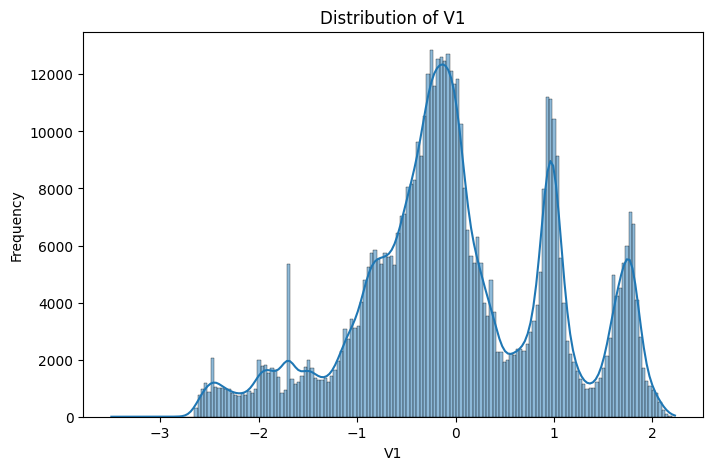

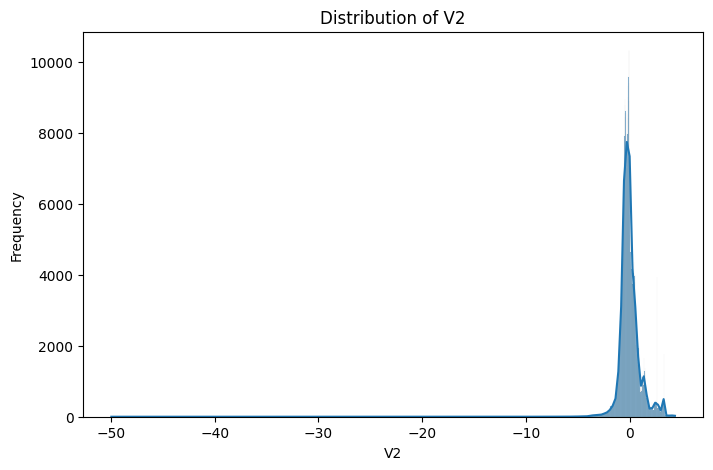

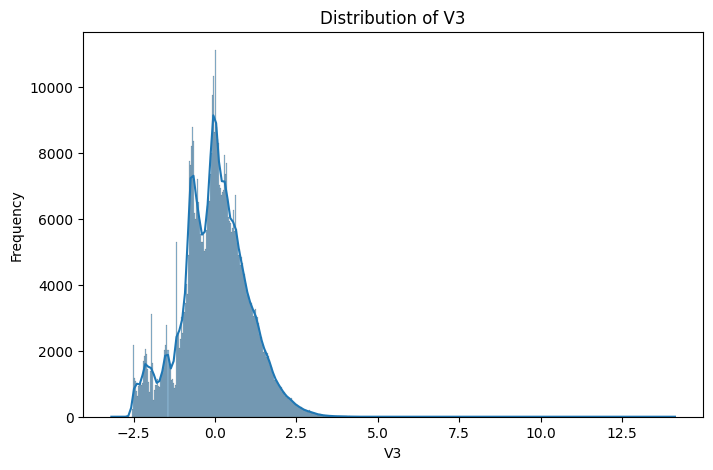

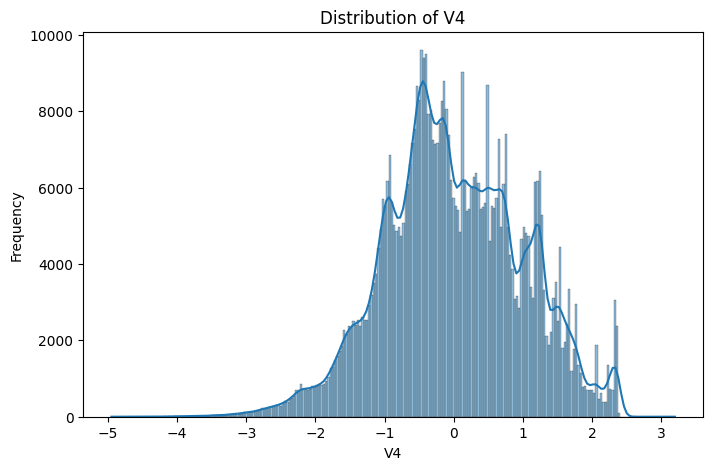

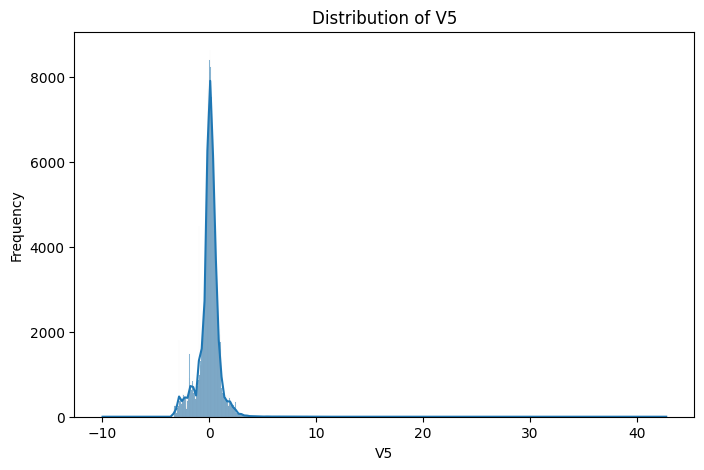

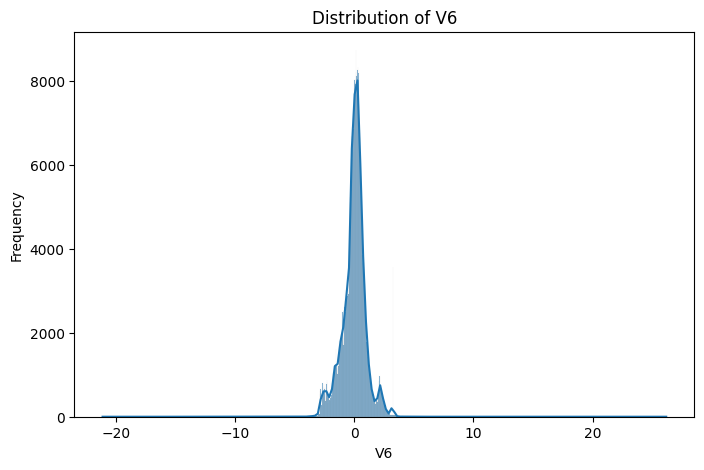

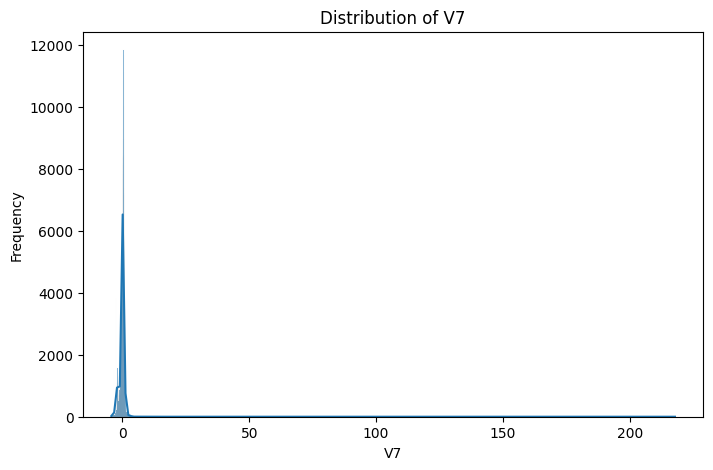

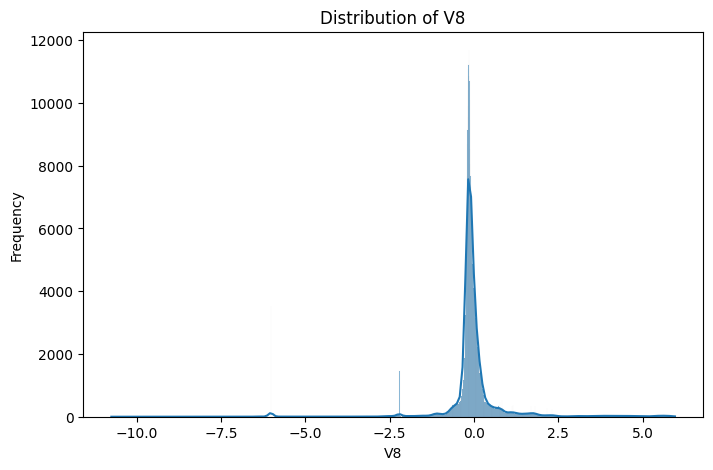

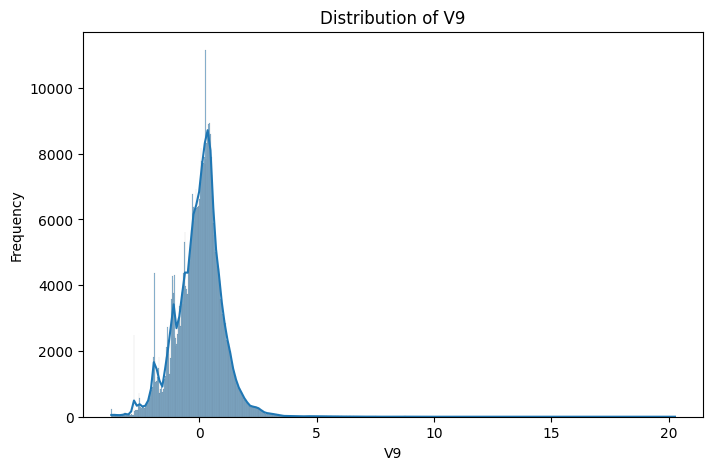

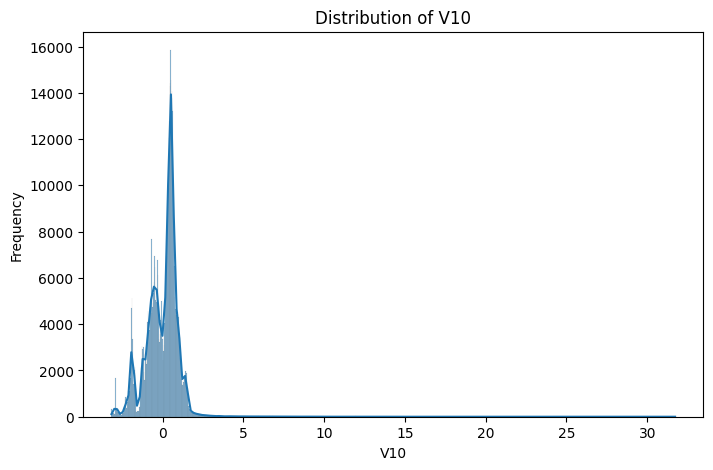

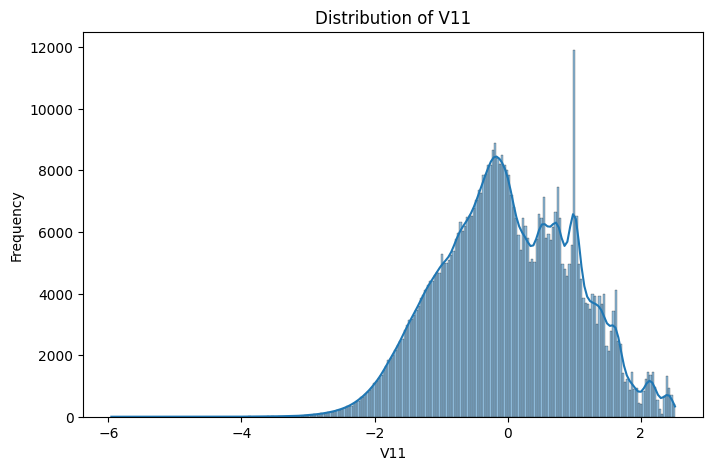

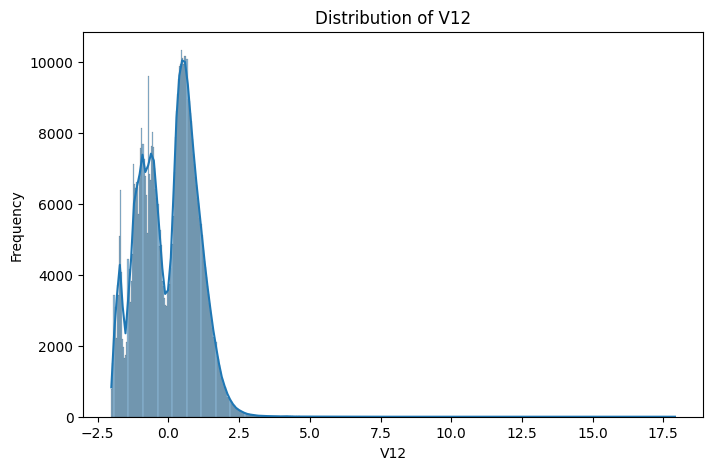

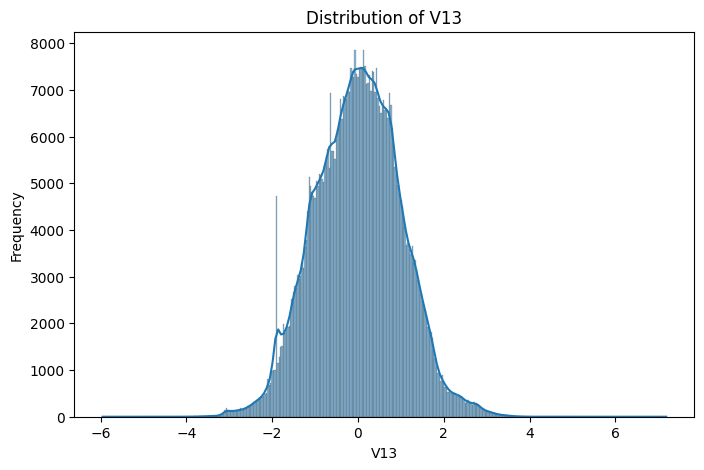

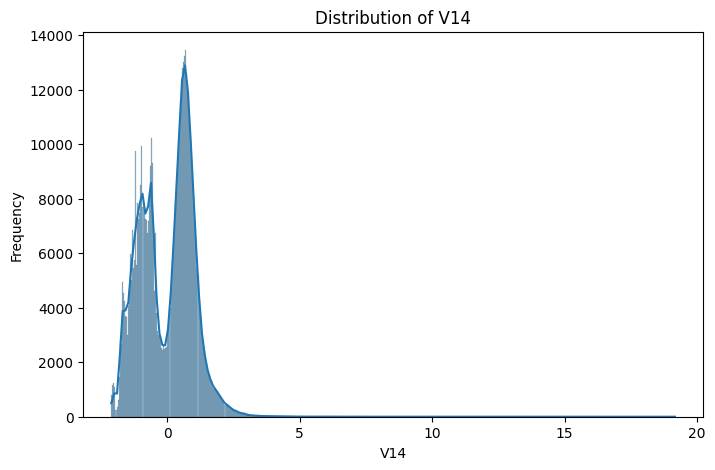

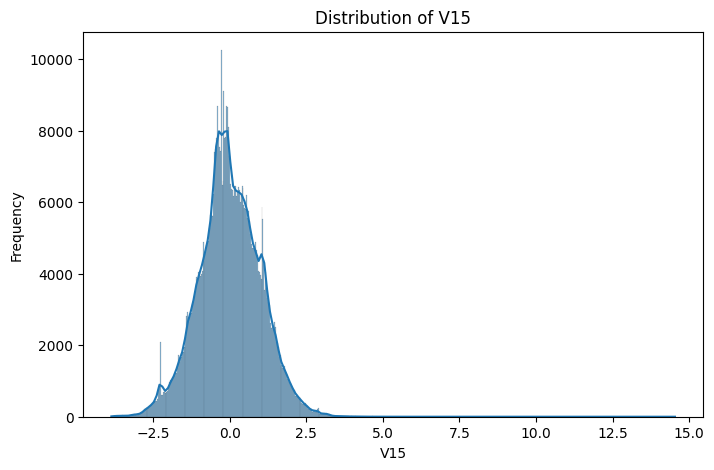

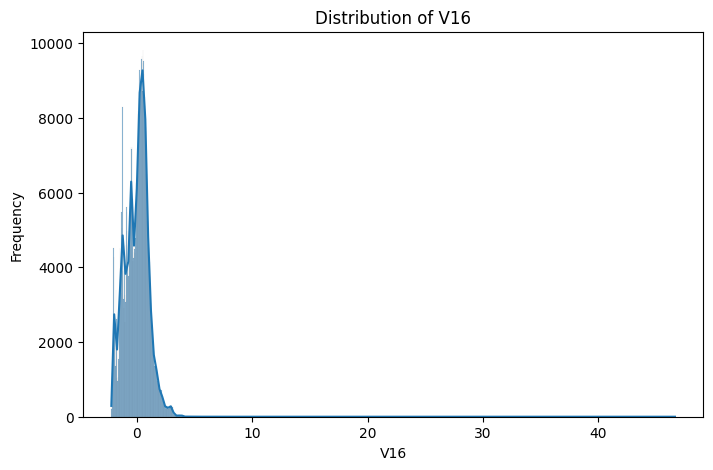

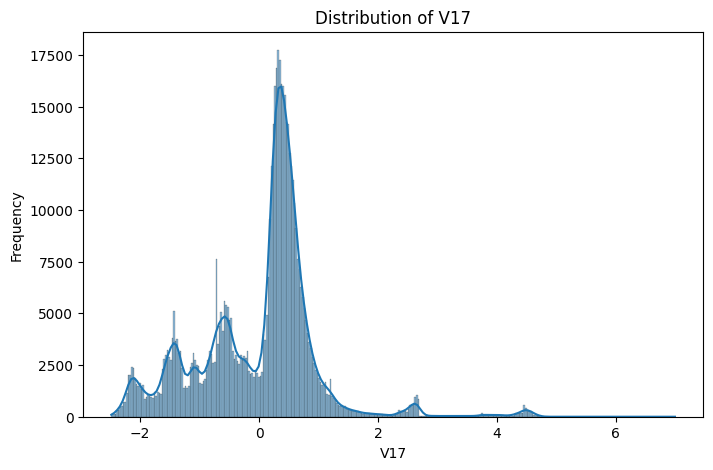

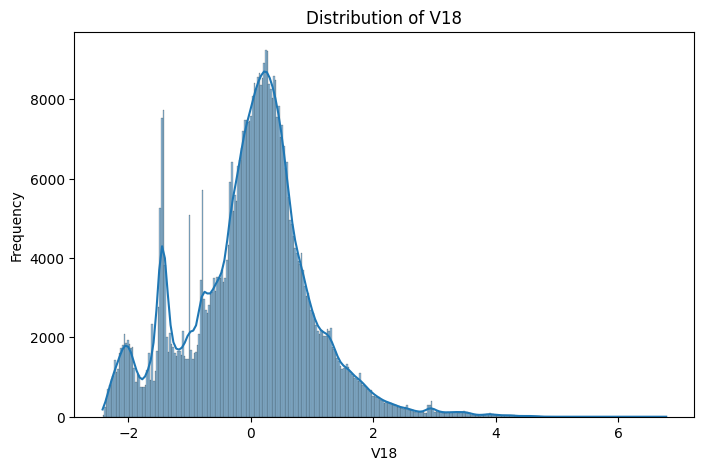

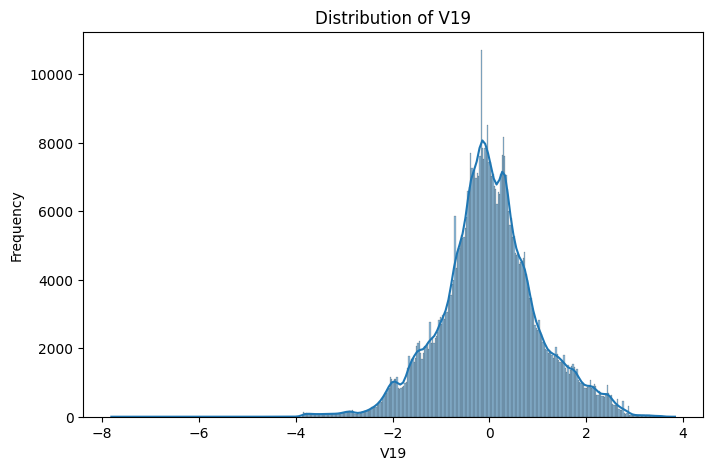

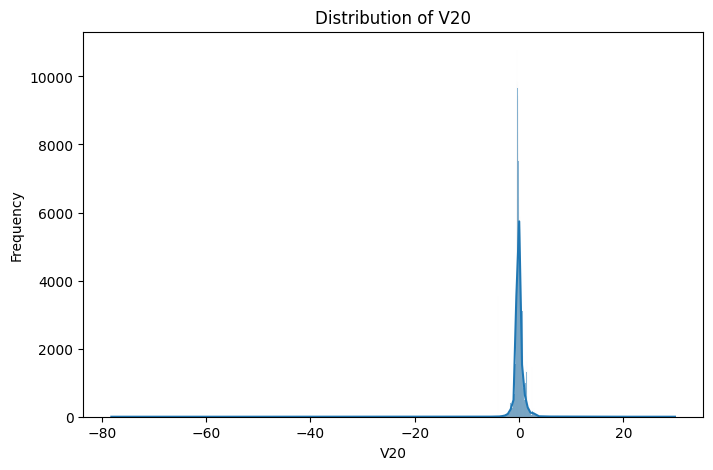

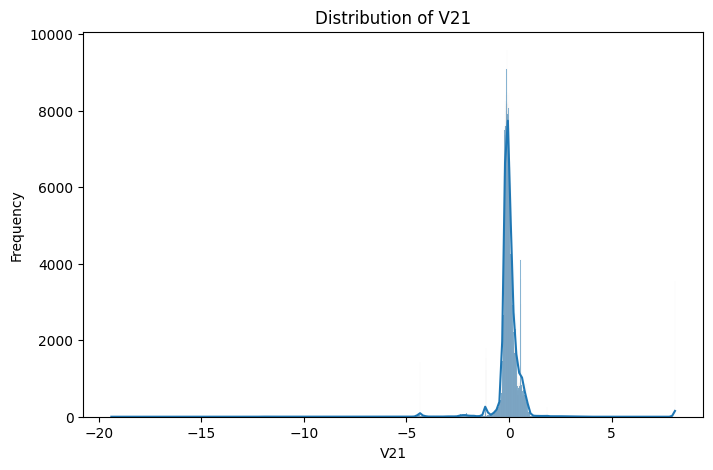

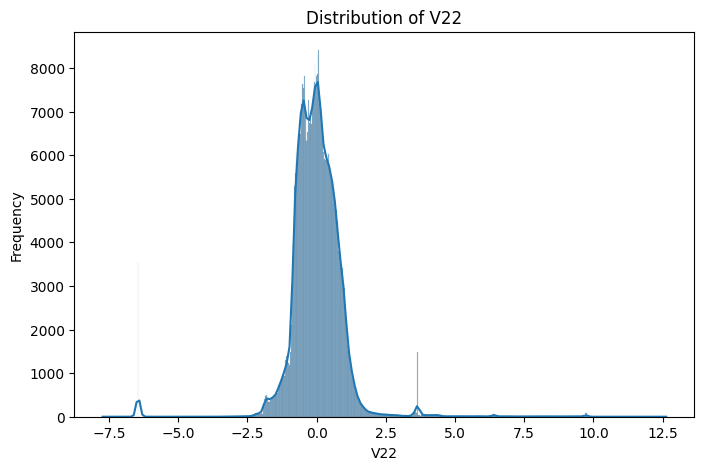

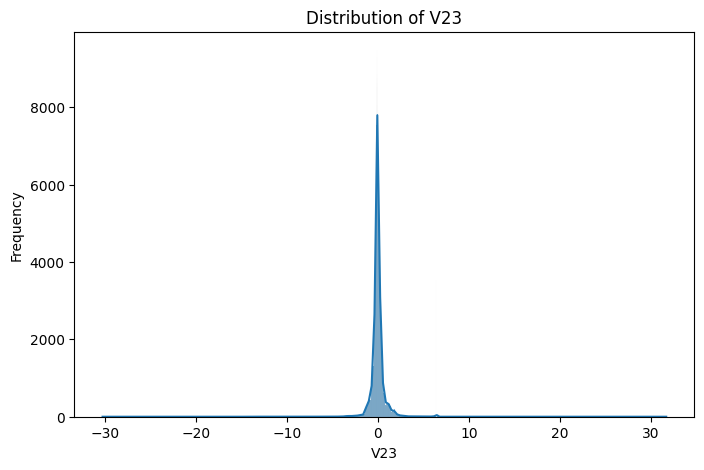

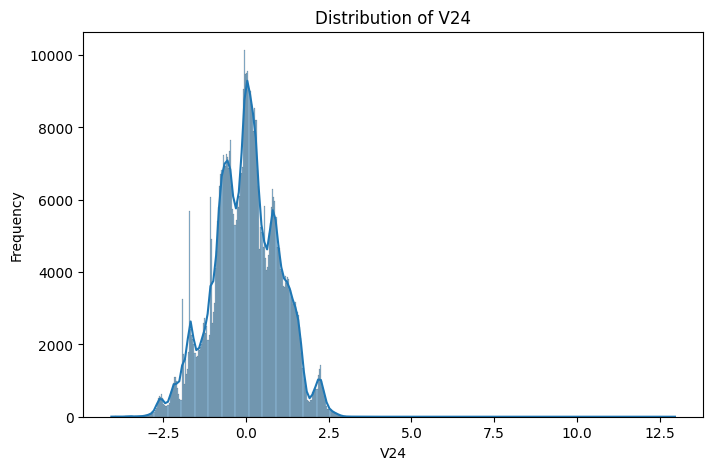

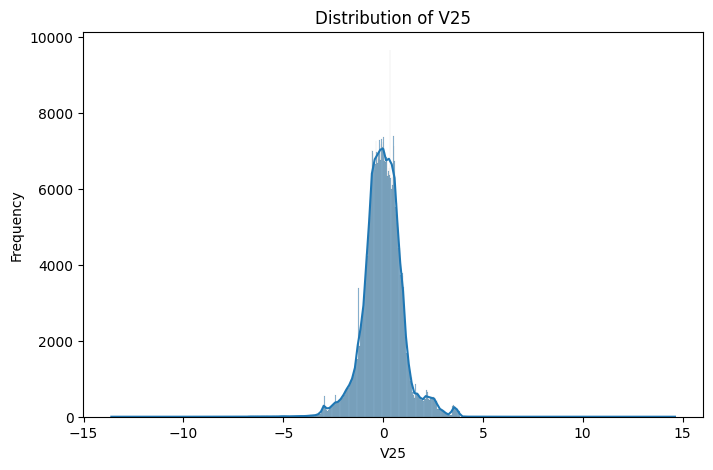

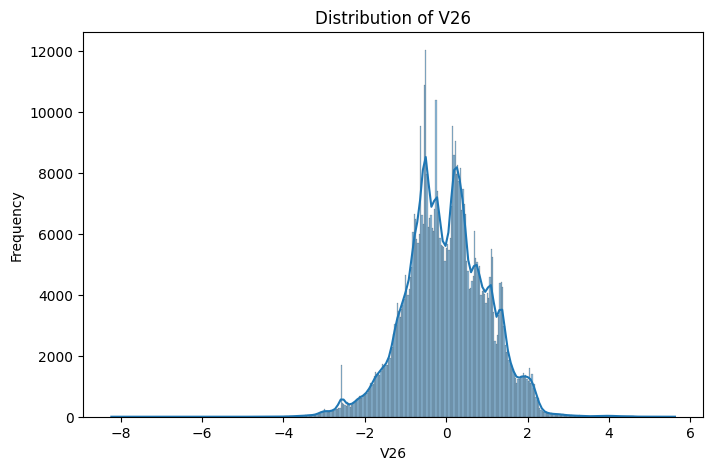

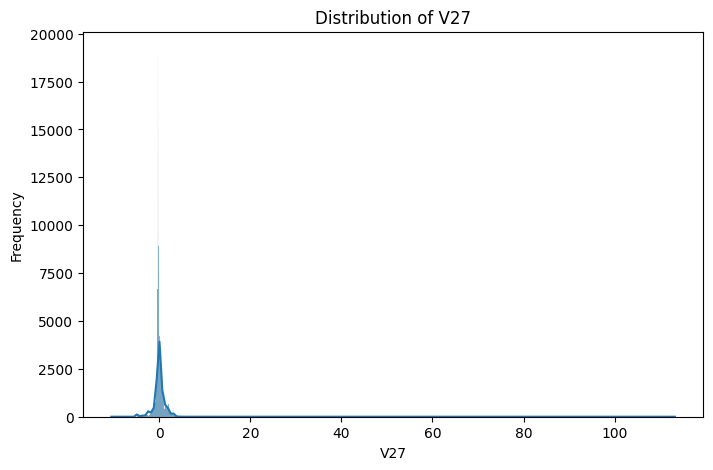

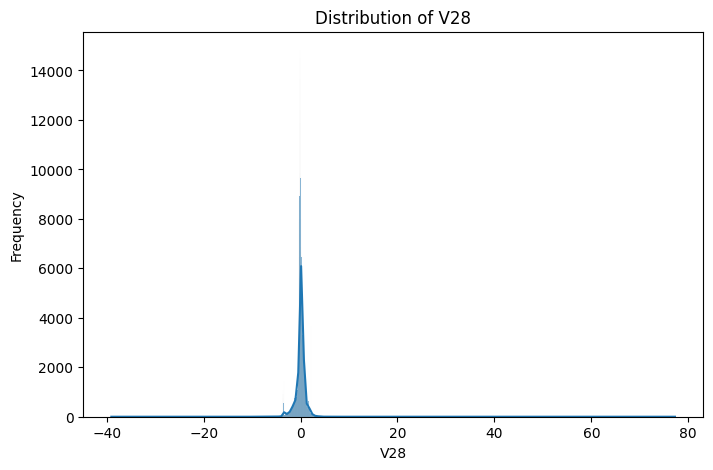

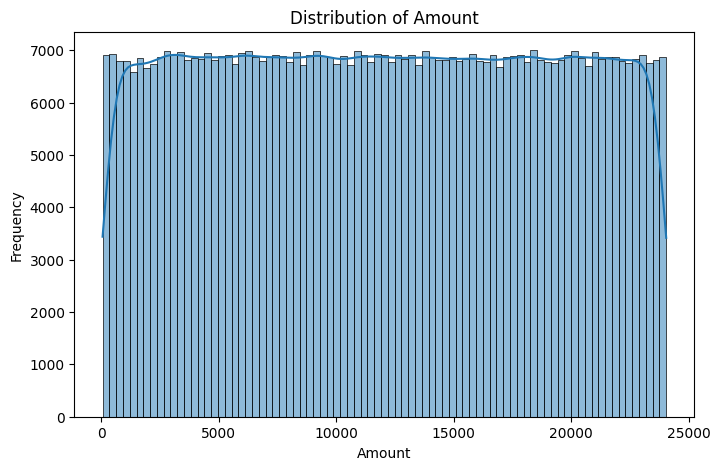

In [15]:
# Assuming numerical_features is your DataFrame containing numerical features
for column in numerical_features.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=numerical_features[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.ylabel('Frequency')
    plt.show()


## Searching About Outliers

<Figure size 1600x800 with 0 Axes>

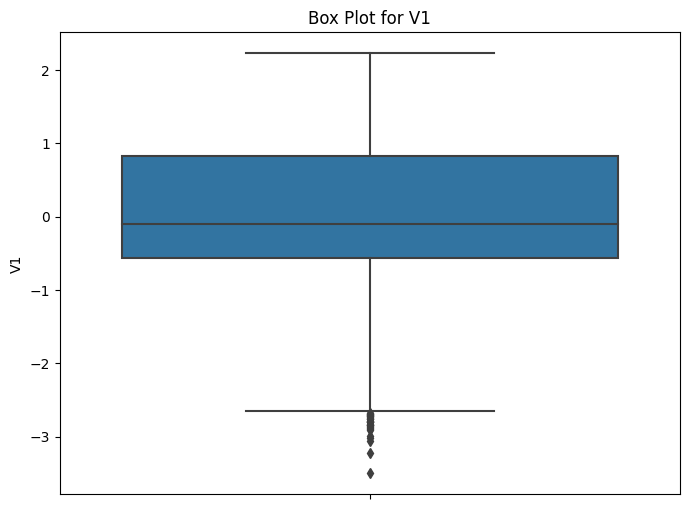

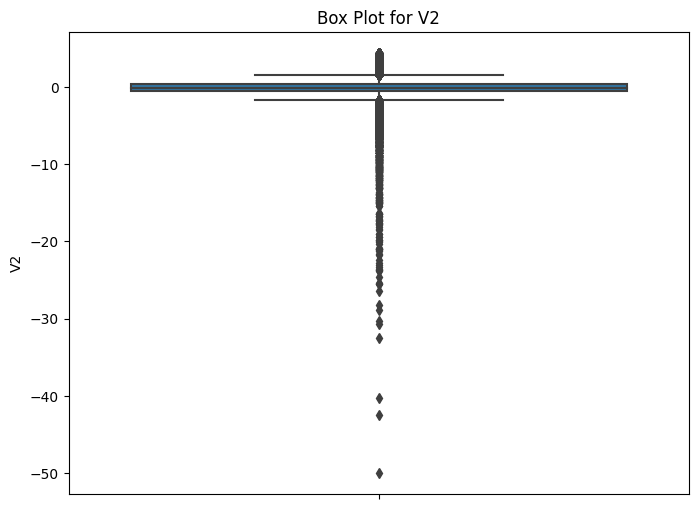

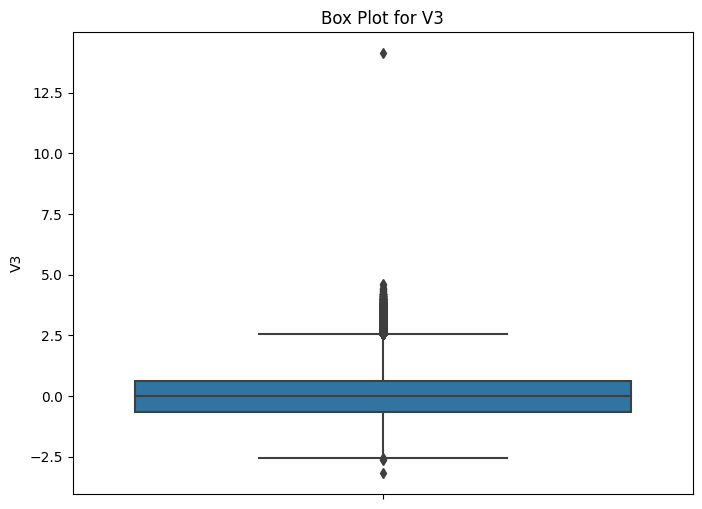

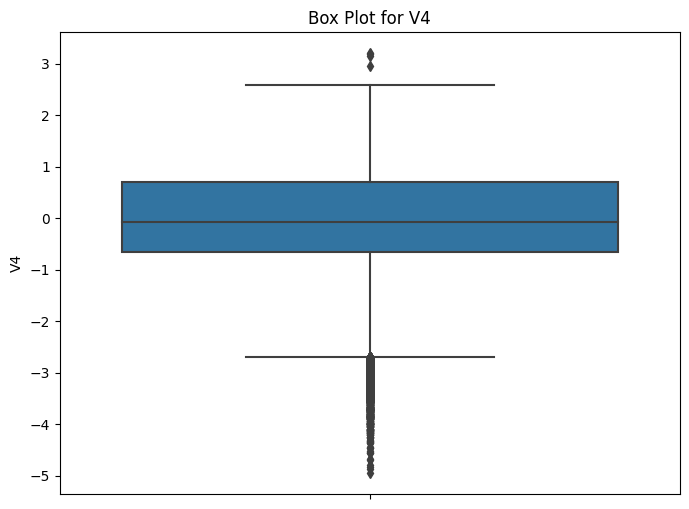

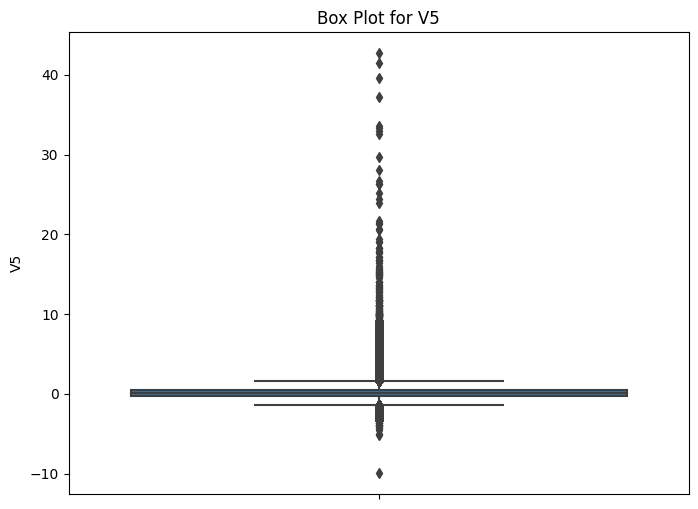

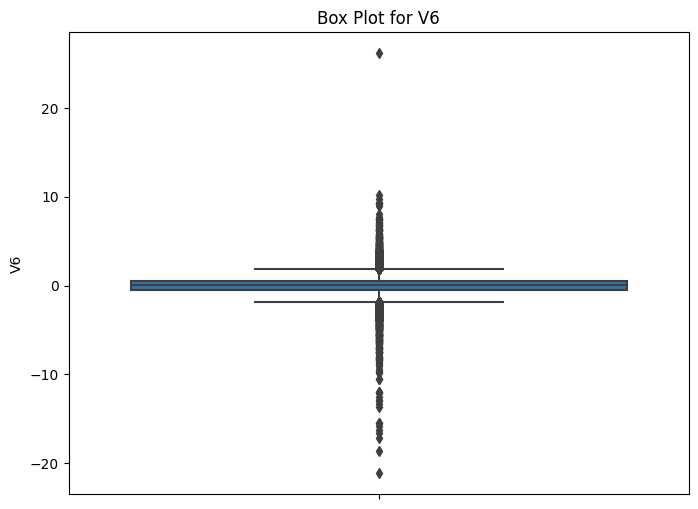

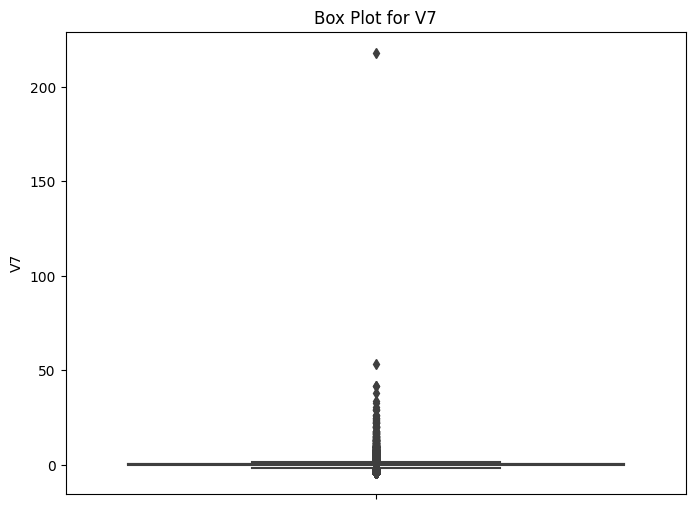

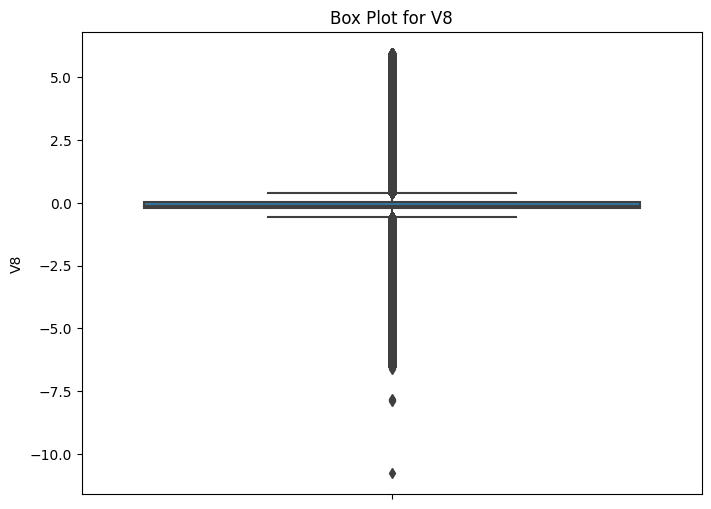

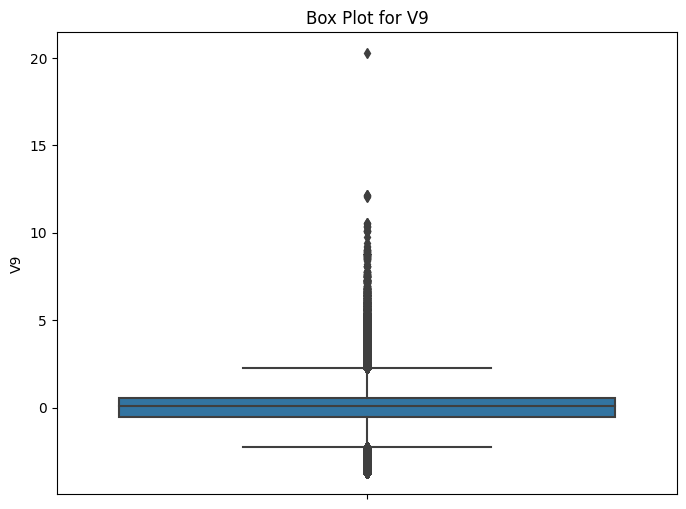

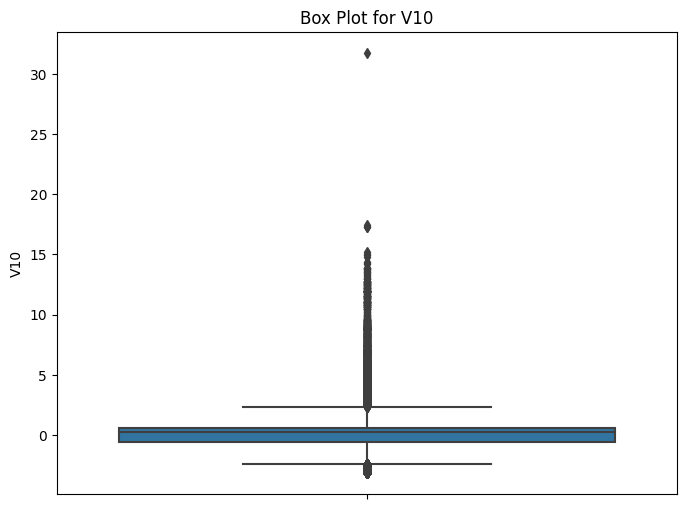

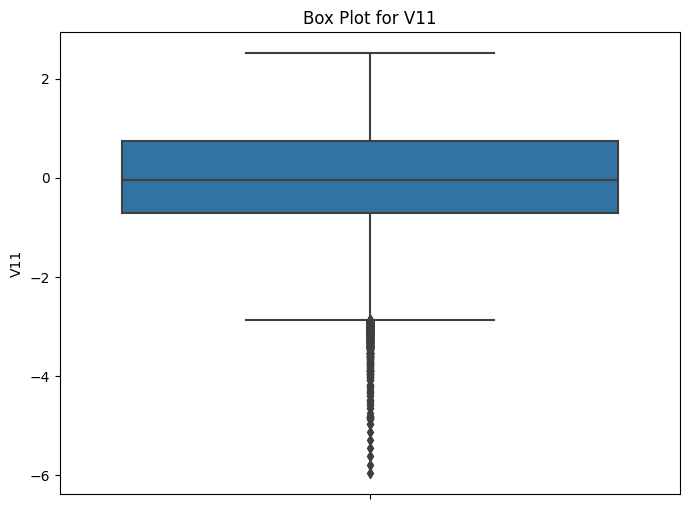

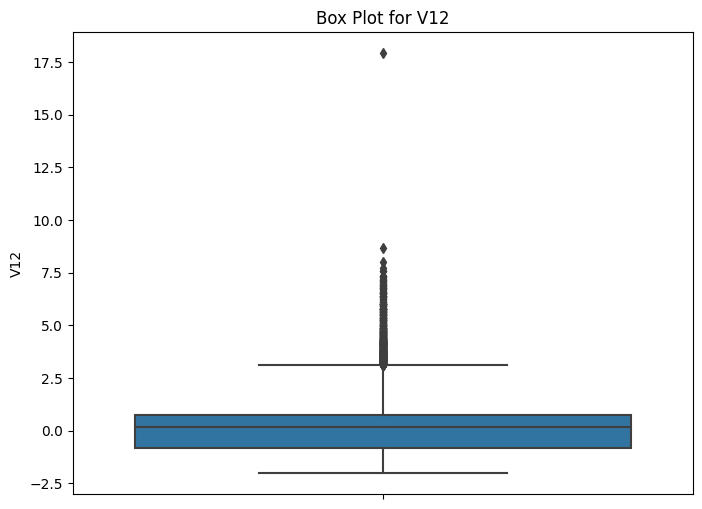

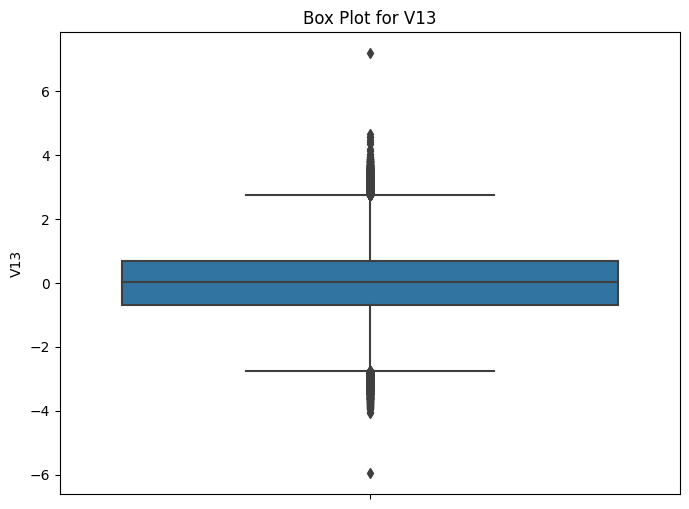

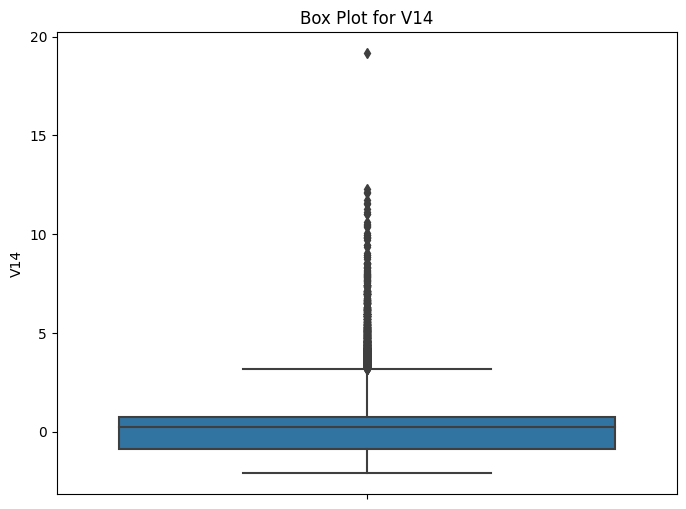

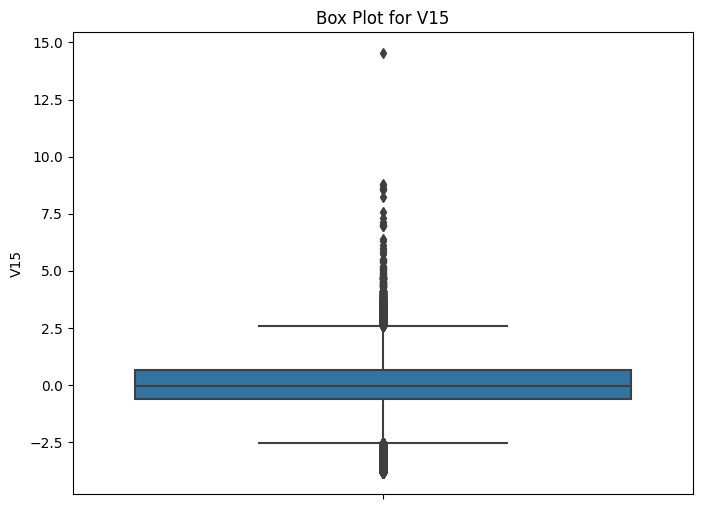

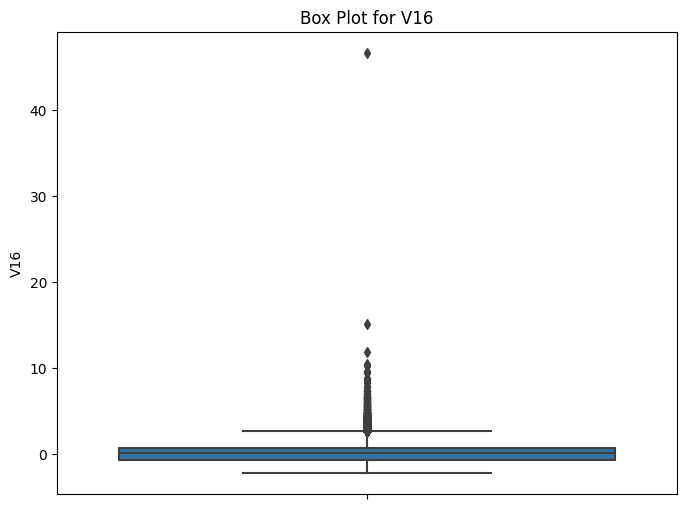

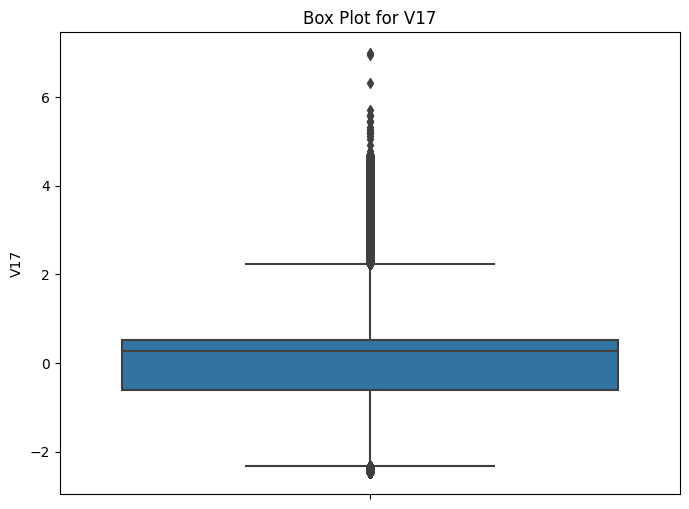

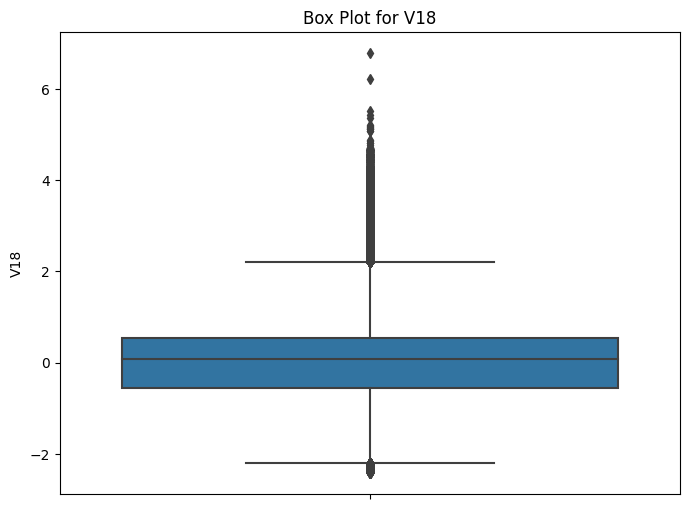

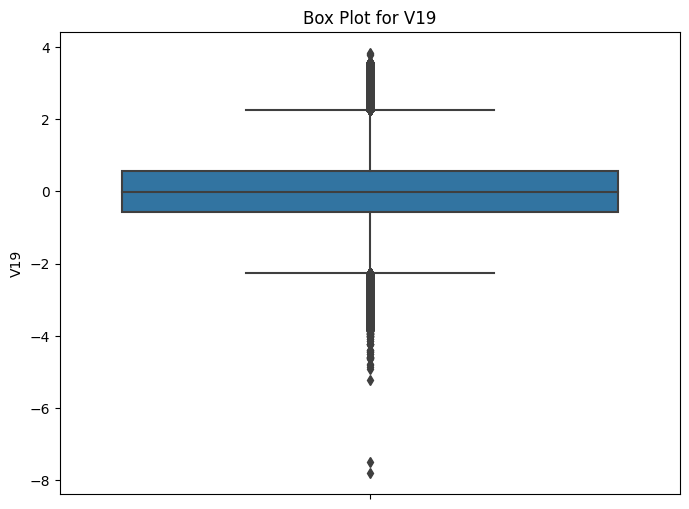

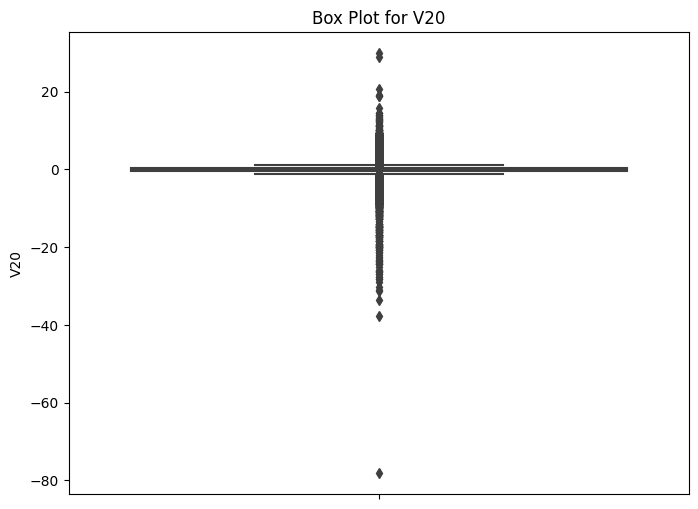

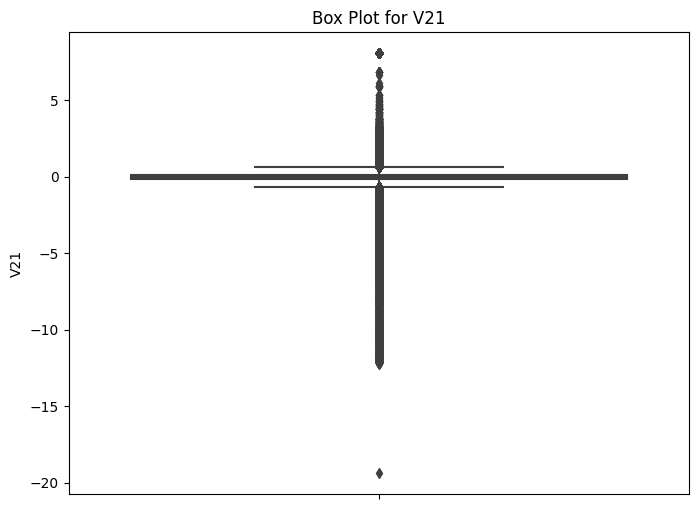

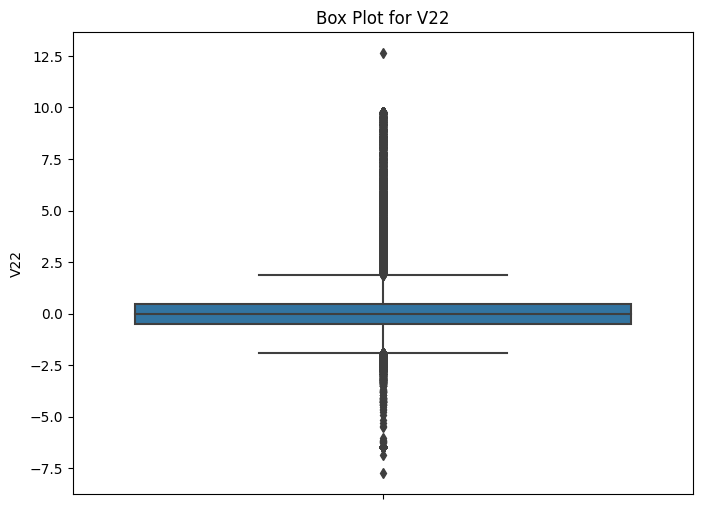

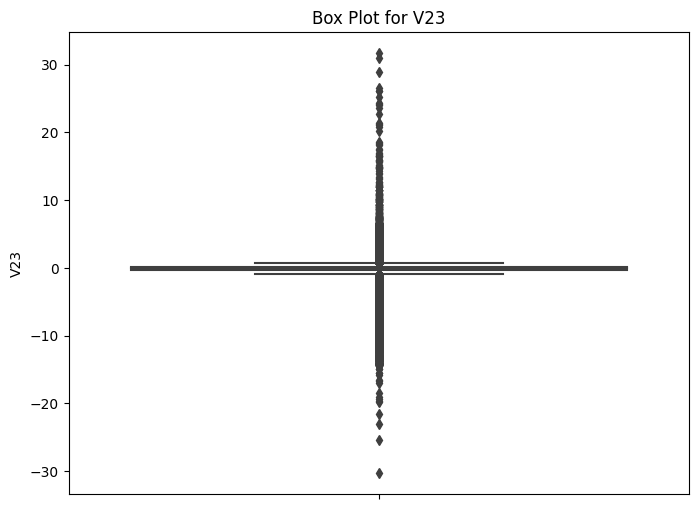

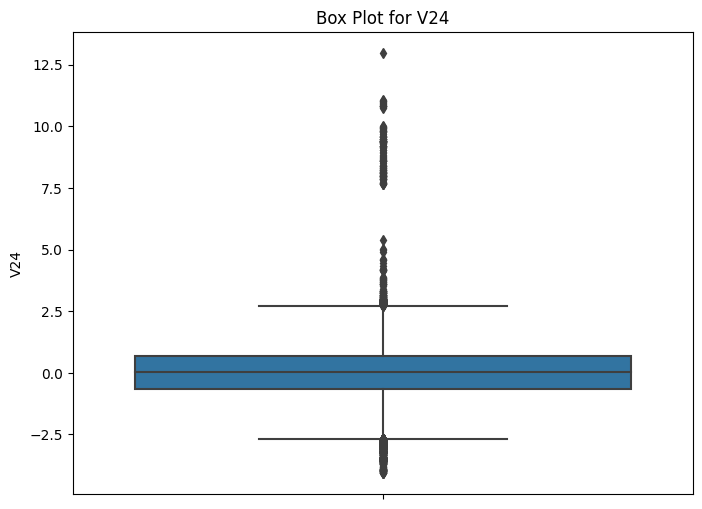

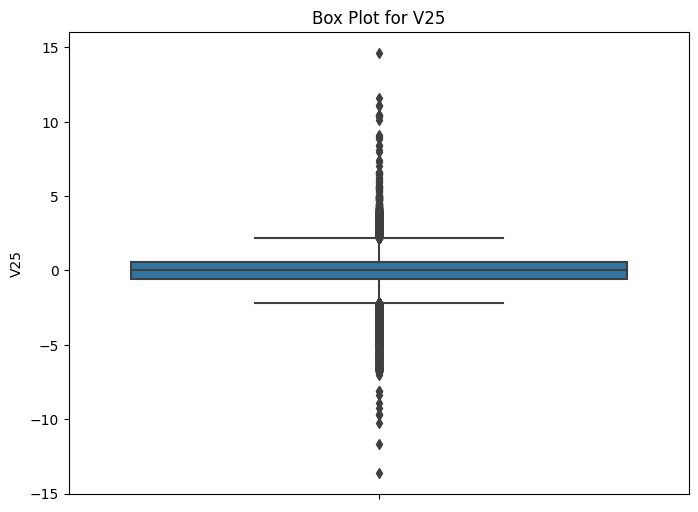

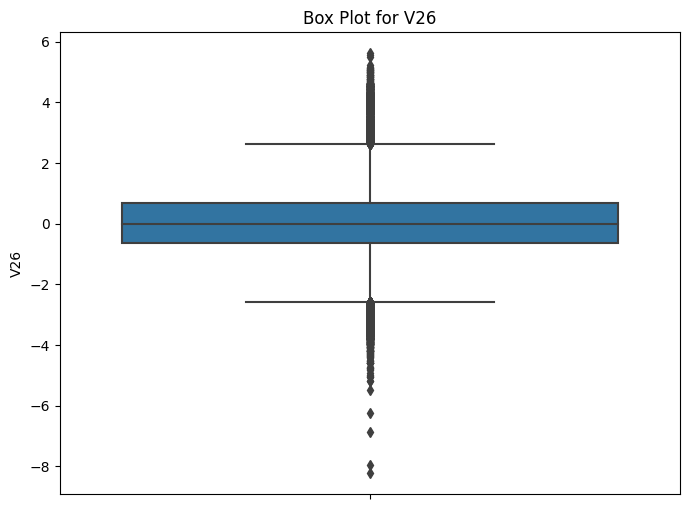

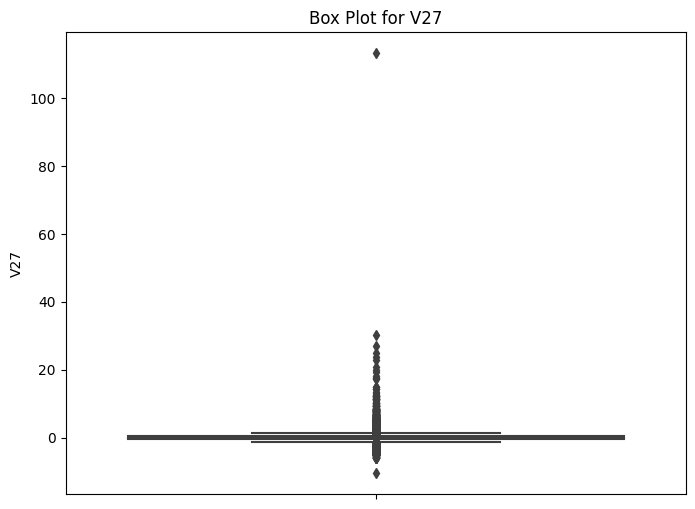

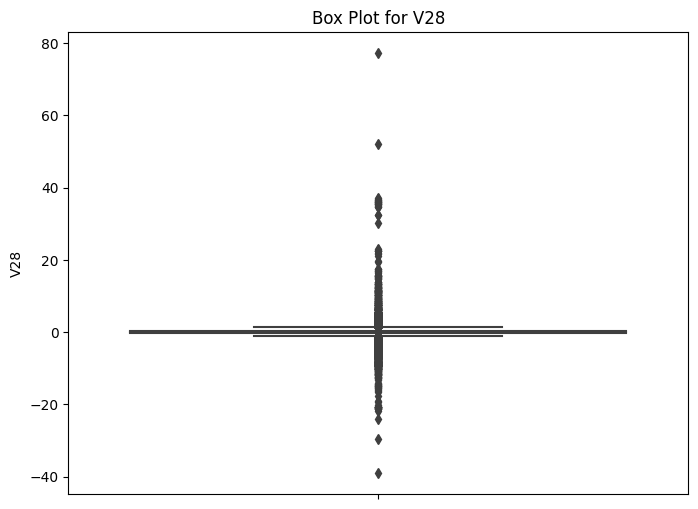

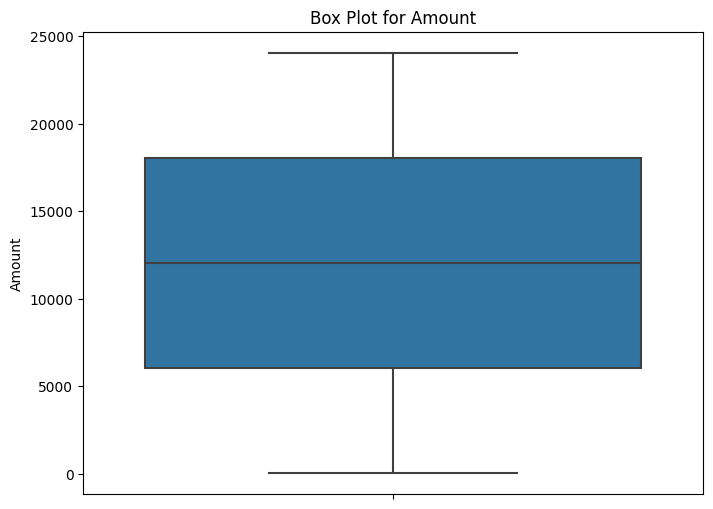

In [16]:
# Set the size of the figure
plt.figure(figsize=(16, 8))

# Iterate through each numerical feature and create a box plot
for column in numerical_features.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=numerical_features[column])  # Use 'y' instead of 'x'
    plt.title(f'Box Plot for {column}')
    plt.show()

## Check for multicollinearity

In [17]:
# Compute the VIF for each independent variable
vif = pd.DataFrame()
vif["variable"] = numerical_features.columns
vif["VIF"] = [variance_inflation_factor(numerical_features.values, i) for i in range(numerical_features.shape[1])]
# Select variables with high VIF
high_vif_variables = vif[vif["VIF"] > 10]["variable"]
print(high_vif_variables)

Series([], Name: variable, dtype: object)


there aren't multicollinearity

## Checking Data Integrity

In [18]:
# Check if 'Amount' column has negative values
has_negative_values = (data['Amount'] < 0).any()

if has_negative_values:
    print("The 'Amount' column has negative values.")
else:
    print("The 'Amount' column does not have negative values.")

The 'Amount' column does not have negative values.


# Feature engineering and selection

## Applying Filter Methods (correlation analysis)

In [19]:
# Set a threshold for high correlation
threshold = 0.9

# Calculate the correlation matrix
correlation_matrix = data.corr()

#  pairs of highly correlated features
high_correlation_pairs = (correlation_matrix.abs() > threshold) & (correlation_matrix < 1)

# Create a DataFrame for the result
high_correlation_table = pd.DataFrame(columns=['Feature 1', 'Feature 2', 'Correlation'])

for i in range(len(high_correlation_pairs.columns)):
    for j in range(i + 1, len(high_correlation_pairs.columns)):
        if high_correlation_pairs.iloc[i, j]:
            feature_1 = high_correlation_pairs.columns[i]
            feature_2 = high_correlation_pairs.index[j]
            correlation = correlation_matrix.loc[feature_1, feature_2]
            high_correlation_table = high_correlation_table.append({'Feature 1': feature_1,
                                                                    'Feature 2': feature_2,
                                                                    'Correlation': correlation},
                                                                    ignore_index=True)

# create_scrollable_table is defined somewhere in your code
html_high_correlation_table = create_scrollable_table(high_correlation_table, 'high_correlation_table', 'high_correlation_table')

# Display the HTML table to show all features
display(HTML(html_high_correlation_table))

,Feature 1,Feature 2,Correlation


from the correlation analysis, there aren't features that have a high correlation together

## Applying Variance Threshold

In [20]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (adjust as needed)
threshold = 0.1

# Initialize VarianceThreshold with the specified threshold
variance_selector = VarianceThreshold(threshold=threshold)

# Fit the selector to the data
variance_selector.fit(data)

# Get the boolean mask indicating features with variance below the threshold
low_variance_mask = variance_selector.get_support()

# Print the names of features with low variance
low_variance_features = data.columns[~low_variance_mask]
print("Features with Low Variance:", low_variance_features)


Features with Low Variance: Index([], dtype='object')


from Variance Threshold there aren't features with low variance

# Creating Pipelines and making predictions

- I made a pipeline for the Kmeans model and GaussianMixture model to be apple from predict labels for each data point, and for each model, I applied
 1. Data Preprocessing using MinMax Scaler
 2. handling missing values with means
 3. Fitting the pipelines and predict labels


In [21]:
# Split the data into features (x) and label variable (y)
y = data['Class']
x = data.drop([ 'Class'], axis=1)

In [22]:
# Define a callable class for custom rank transformation
class CustomRankTransformer:
    def transform(self, X):
        return X.rank()

In [23]:
# kmeans pipeline
kmeans_pipeline_model = Pipeline([
    ('preprocess', ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('drop_id', 'drop', ['id']),
            ('rank_transform', FunctionTransformer(func=CustomRankTransformer().transform),  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'])
        ]
    )),
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

In [24]:
# GaussianMixture pipeline
GaussianMixture_pipeline_model = Pipeline([
    ('preprocess', ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('drop_id', 'drop', ['id']),
            ('rank_transform', FunctionTransformer(func=CustomRankTransformer().transform),  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                        'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                        'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'])
        ]
    )),
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('gmm', GaussianMixture(n_components=2, random_state=42))
])

In [25]:
## Defining the pipelines in a list
models_pipeline = [kmeans_pipeline_model, GaussianMixture_pipeline_model]

# Creating dictionary of pipelines and training models
PipelineDict = {0: 'kmeans_pipeline_model', 1: 'GaussianMixture_pipeline_model'}

In [26]:
# Fit the pipelines and predict labels
for model_key, model_name in PipelineDict.items():
    model = models_pipeline[model_key]

    # Fit the model to the data
    model.fit(x)

    # Predict labels
    labels = model.predict(x)

    # Calculate correct labels
    correct_labels = sum(y == labels)

    # Print the results
    print("Results for {}: ".format(model_name))
    print("  Correct labels: {}/{}".format(correct_labels, y.size))
    print("  Accuracy score: {:.2f}%\n".format(correct_labels / float(y.size) * 100))

Results for kmeans_pipeline_model: 
  Correct labels: 511824/568630
  Accuracy score: 90.01%

Results for GaussianMixture_pipeline_model: 
  Correct labels: 522139/568630
  Accuracy score: 91.82%



# Pickel The Best Model

In [27]:
import pickle
filename = 'gmm_model.sav'
pickle.dump(GaussianMixture_pipeline_model, open(filename, 'wb'))

# loading the saved model
loaded_model = pickle.load(open('gmm_model.sav', 'rb'))